hello


[]

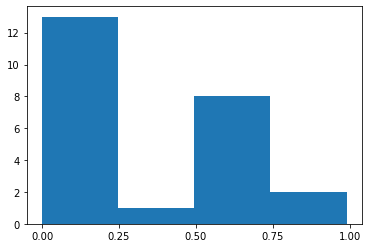

In [11]:
import matplotlib.pyplot as plt
print("hello")


'''
- i = get classification probabilities
- determine the bins
- determine students that fit within their
respective bins
- determine those who are TP and FP
  (probably determined beforehand somehow)
- loop through student list, summing
  all the empirical risks and then getting
  the mean
- Plot

- The empirical risk curve will most likely
  not resemble the paper, so there might
  need to be changes.
'''

i = [0.68, 0.68, 0.09, 0.0, 0.7384047619047618, 0.6191666666666668,
     0.7100714285714286, 0.72, 0.64, 0.23, 0.99, 0.0, 0.0, 0.0,
     0.5143333333333332, 0.0, 0.0, 0.96, 0.0, 0.0, 0.39, 0.0, 0.0, 0.0]

plt.hist(i, bins=4)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.plot()
